# Лабораторна робота 1: Базові алгоритми класифікації з використанням бібліотеки Scikit-learn

**Викладач:** Наталія Сахненко

**Студент:** Зубко Дмитро Едуардович

## Опис завдання

Виконати наступне:
1. Завантажити дані, вивести назви колонок і розмір датасета.
2. Опрацювати пропуски (по можливості заповнити їх або видалити).
3. Візуалізувати дані: побудувати heatmap кореляцій ознак між собою і з цільовою змінною; побудувати гістограми та boxplot-и для кількох ознак.
4. Нормалізувати дані.
5. Навчити класифікатори kNN, Decision Tree, SVM, Random Forest, AdaBoost.
6. Підібрати оптимальні параметри для kNN та SVM.
7. Вивести classification_report і confusion_matrix для кожної моделі.


In [1]:
# Імпортуємо потрібні бібліотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Крок 1: Завантаження даних

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
# 3. Перетворення категоріальних змінних у числові
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = pd.Categorical(df[col]).codes

numeric_features = df.columns.drop('diabetes')  # Виключаємо цільову змінну

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99982 entries, 0 to 99981
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  int8   
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  int64  
 3   heart_disease        99982 non-null  int64  
 4   smoking_history      99982 non-null  int8   
 5   bmi                  99982 non-null  float64
 6   HbA1c_level          99982 non-null  float64
 7   blood_glucose_level  99982 non-null  int64  
 8   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(4), int8(2)
memory usage: 5.5 MB


## Крок 2: Опрацювання пропусків

In [4]:
print("\nКількість пропусків у кожній колонці:")
print(df.isnull().sum())


Кількість пропусків у кожній колонці:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [5]:
df.dropna(inplace=True)

print("\nКількість пропусків після видалення:")
print(df.isnull().sum())
print("\nРозмір датасету після обробки пропусків:", df.shape)


Кількість пропусків після видалення:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Розмір датасету після обробки пропусків: (99982, 9)


## Крок 3: Візуалізація даних
### Кореляційна матриця

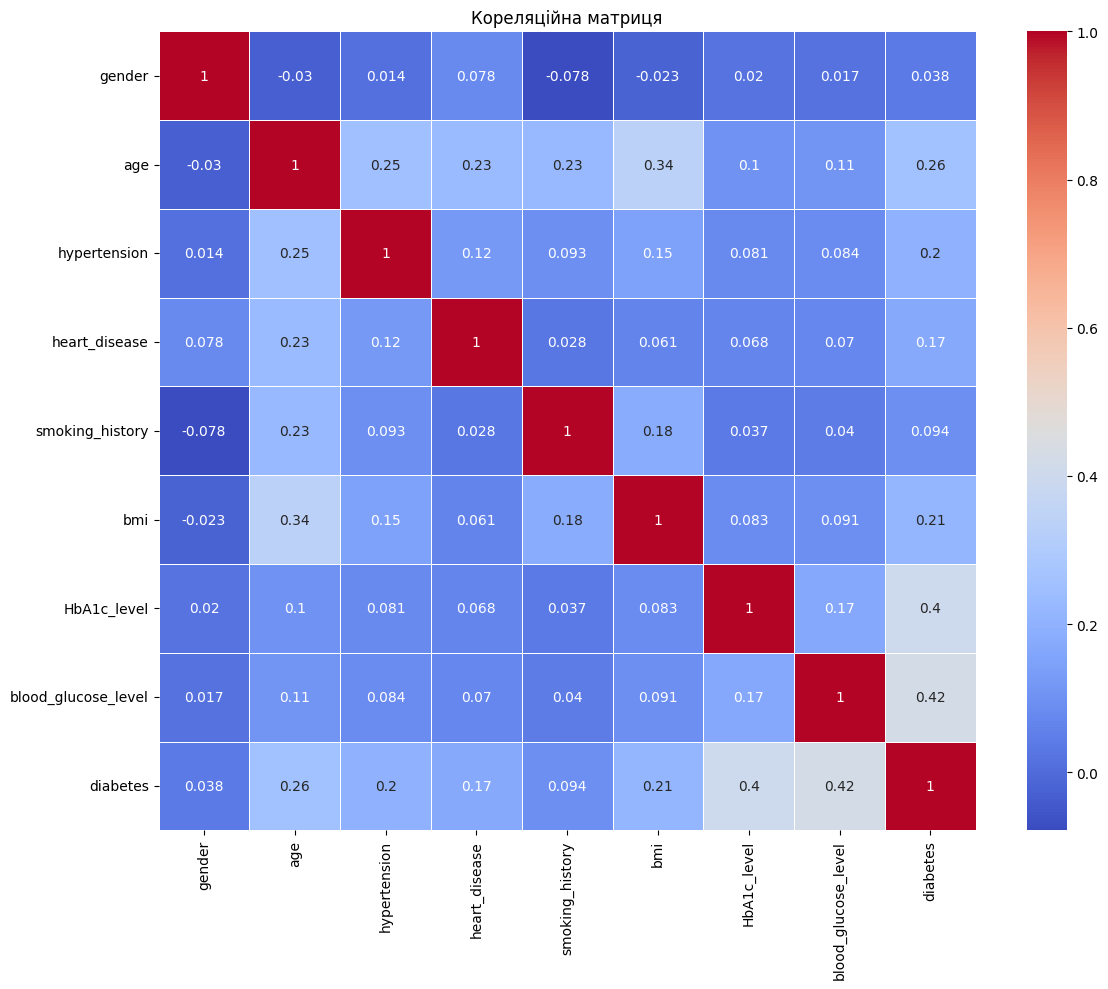

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна матриця')
plt.tight_layout()
plt.show()

### Гістограми для розподілу ознак

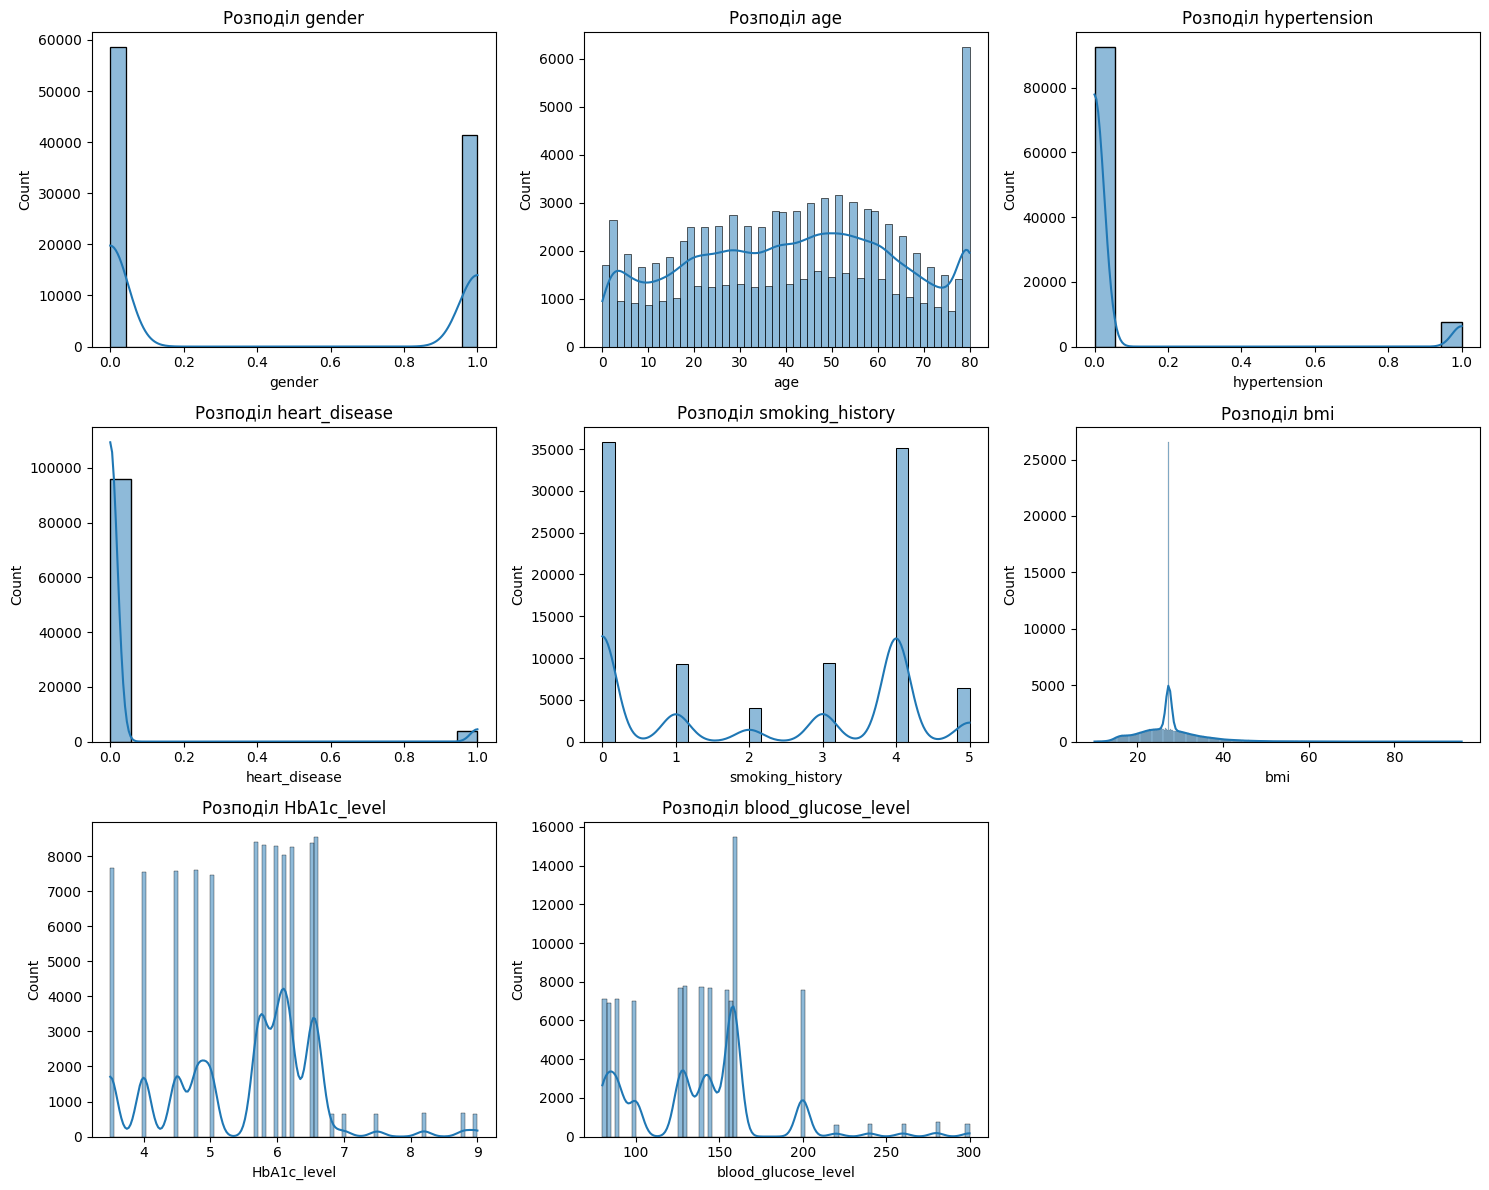

In [7]:
n_cols = 3
n_rows = (len(numeric_features) - 1) // n_cols + 1
plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Розподіл {feature}')
plt.tight_layout()
plt.show()

### Boxplot для кількох ознак відносно цільової змінної

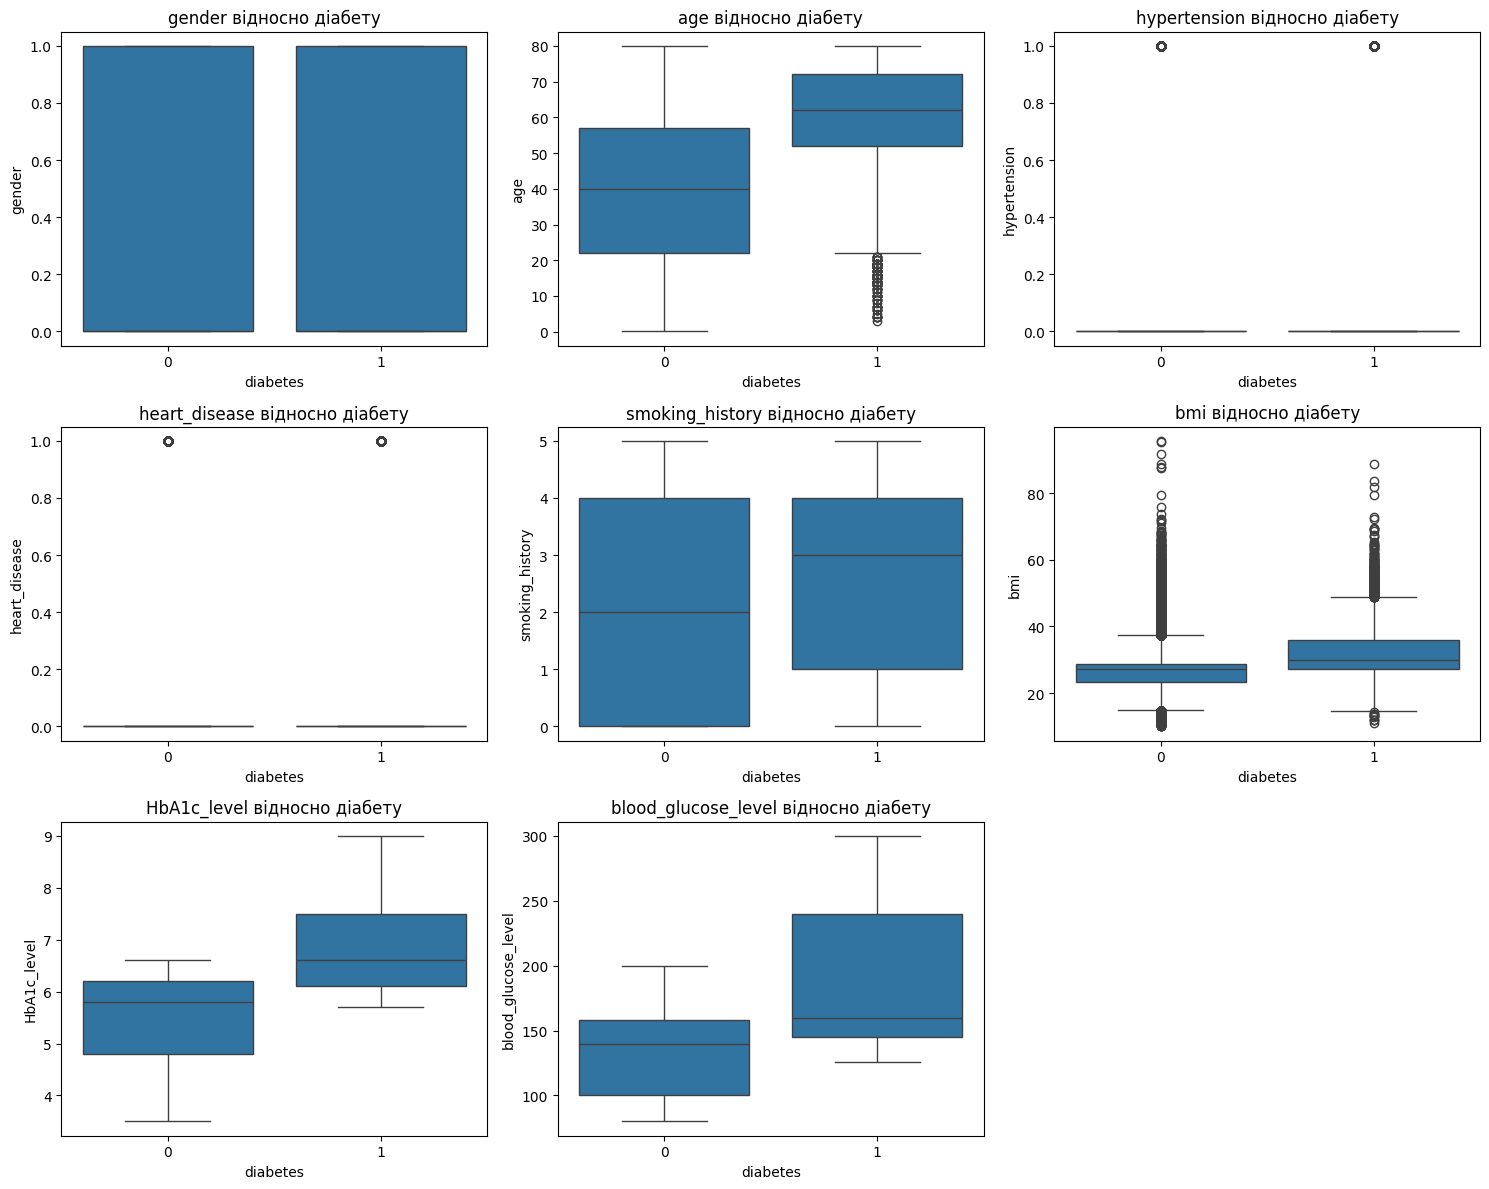

In [8]:
# Boxplot-и ознак відносно цільової змінної
plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='diabetes', y=feature, data=df)
    plt.title(f'{feature} відносно діабету')
plt.tight_layout()
plt.show()

### Pairplot

<Figure size 1200x1000 with 0 Axes>

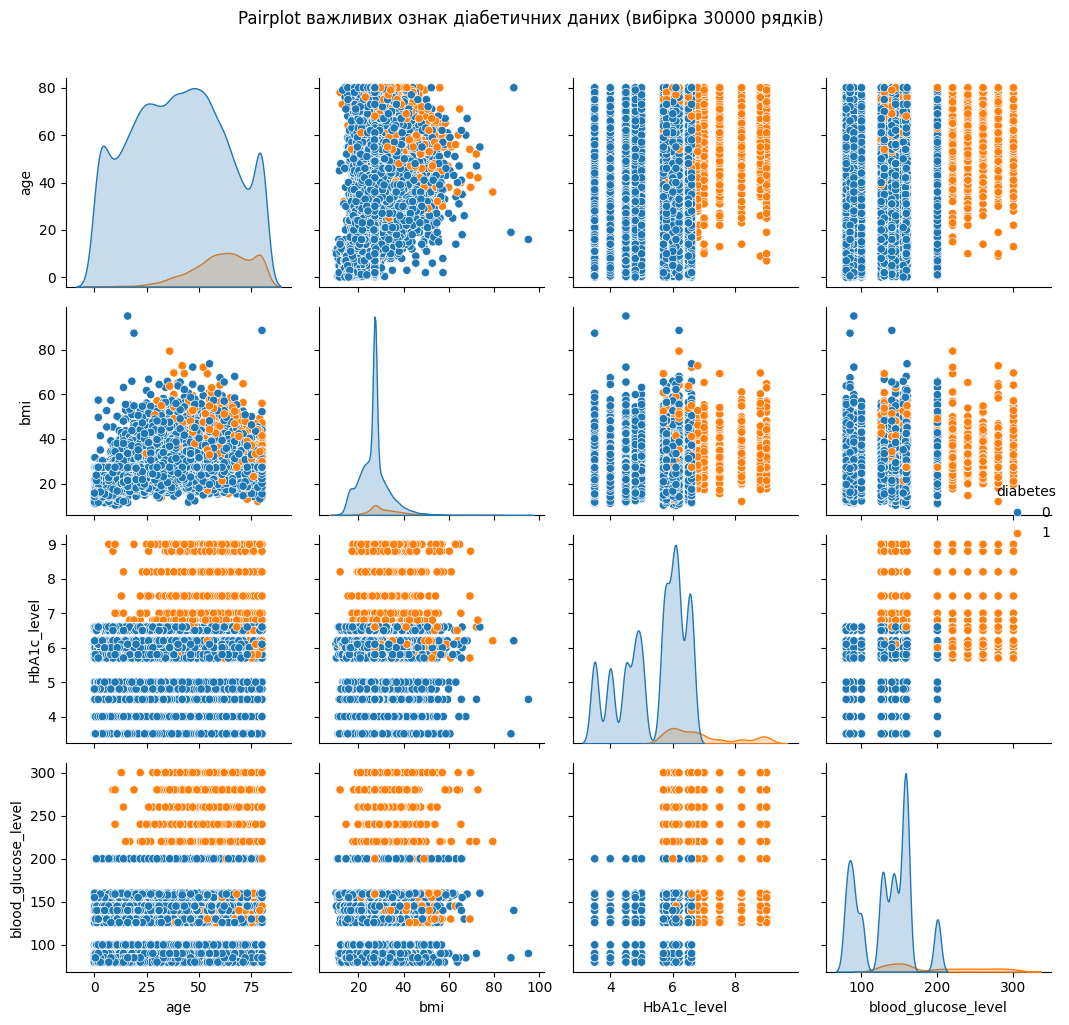

In [9]:
df_sample = df.sample(n=30000, random_state=42)

# Визначаємо важливі ознаки
important_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Створюємо Pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(df_sample, hue='diabetes', vars=important_features, diag_kind='kde')
plt.suptitle('Pairplot важливих ознак діабетичних даних (вибірка 30000 рядків)', y=1.02)
plt.tight_layout()
plt.show()

## Крок 4: Нормалізація даних

In [68]:
# Розділення на групи з діабетом та без
df_diabetes = df[df['diabetes'] == 1]
df_no_diabetes = df[df['diabetes'] == 0]

# Визначення розміру меншої групи
min_size = min(len(df_diabetes), len(df_no_diabetes))

# Вибір рівної кількості зразків з обох груп
df_diabetes_sampled = df_diabetes.sample(n=min_size, random_state=42)
df_no_diabetes_sampled = df_no_diabetes.sample(n=min_size, random_state=42)

# Об'єднання вибірок
df_balanced = pd.concat([df_diabetes_sampled, df_no_diabetes_sampled])

# Перемішування даних
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Виділення ознак та цільової змінної
X = df_balanced.drop('diabetes', axis=1)
y = df_balanced['diabetes']

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перевірка балансу класів
print("Розподіл класів у тренувальному наборі:")
print(y_train.value_counts(normalize=True))
print("\nРозподіл класів у тестовому наборі:")
print(y_test.value_counts(normalize=True))

# 4. Нормалізація даних
scaler = StandardScaler()
scaler.fit(X_train)

Розподіл класів у тренувальному наборі:
diabetes
1    0.500147
0    0.499853
Name: proportion, dtype: float64

Розподіл класів у тестовому наборі:
diabetes
0    0.500588
1    0.499412
Name: proportion, dtype: float64


StandardScaler()

In [69]:
scaled_X_train = scaler.transform(X_train) 
scaled_X_test = scaler.transform(X_test) 

## Крок 5: Навчання моделей класифікації

### KNN (k-Nearest Neighbors)

In [70]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(scaled_X_train, y_train)

KNeighborsClassifier()

In [71]:
pred = knn.predict(scaled_X_test)

#### Оцінка knn

In [72]:
print(confusion_matrix(y_test,pred))

[[1496  206]
 [ 175 1523]]


In [73]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1702
           1       0.88      0.90      0.89      1698

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400



#### Підбір оптимального k для kNN

In [74]:
error_rate = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scaled_X_train,y_train)
    pred_i = knn.predict(scaled_X_test)
    error_rate.append(np.mean(pred_i != y_test))

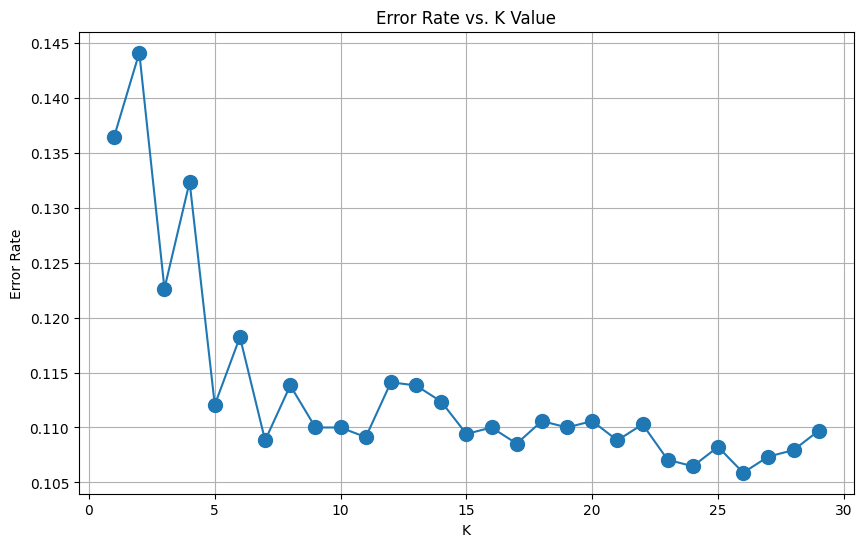

In [75]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [121]:
knn = KNeighborsClassifier(n_neighbors=26)

knn.fit(scaled_X_train,y_train)
pred = knn.predict(scaled_X_test)

print(confusion_matrix(y_test,pred))
print()
print(classification_report(y_test,pred))

[[1496  206]
 [ 154 1544]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1702
           1       0.88      0.91      0.90      1698

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400



### Decision Tree (Дерево ухвалення рішень)

In [77]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(criterion='gini')

In [78]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [79]:
y_pred = model.predict(X_test)

#### Оцінка

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1702
           1       0.88      0.87      0.87      1698

    accuracy                           0.87      3400
   macro avg       0.87      0.87      0.87      3400
weighted avg       0.87      0.87      0.87      3400



In [81]:
print(confusion_matrix(y_test, y_pred))

[[1497  205]
 [ 224 1474]]


#### Візуалізація

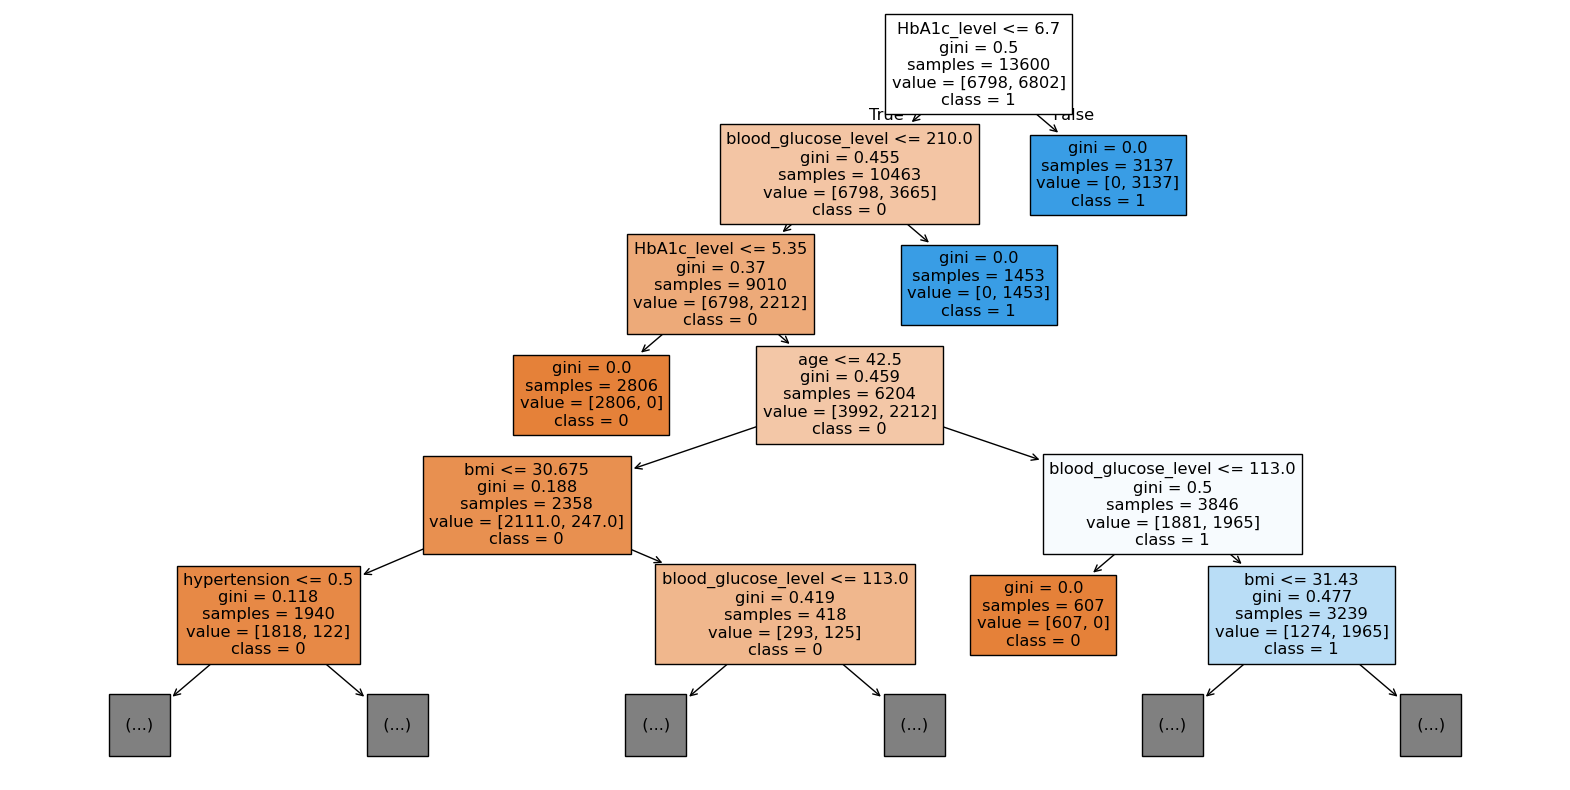

In [82]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=numeric_features, 
          class_names=['0', '1'], filled=True,
          max_depth=5)  # Обмежуємо глибину до 5 рівнів
plt.show()

### SVM

In [83]:
model = SVC(C=1.0, gamma = 1.0, kernel = 'rbf')

In [84]:
model.fit(scaled_X_train,y_train)

SVC(gamma=1.0)

In [85]:
y_pred = model.predict(scaled_X_test)

#### Оцінка

In [86]:
print(confusion_matrix(y_test, y_pred))

[[1505  197]
 [ 146 1552]]


In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1702
           1       0.89      0.91      0.90      1698

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400



#### Gridsearch

In [88]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [89]:
grid = GridSearchCV(SVC(), param_grid, refit=True)

In [90]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [91]:
grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [92]:
grid.best_estimator_

SVC(C=100, gamma=0.1)

In [93]:
grid_predictions = grid.predict(scaled_X_test)

In [94]:
print(confusion_matrix(y_test,grid_predictions))

[[1513  189]
 [ 142 1556]]


In [95]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1702
           1       0.89      0.92      0.90      1698

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400



### Random Forest

In [97]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [98]:
model.fit(scaled_X_train, y_train)

RandomForestClassifier(random_state=42)

In [99]:
y_pred = model.predict(scaled_X_test)

In [100]:
print("Матриця помилок:")
print(confusion_matrix(y_test, y_pred))

Матриця помилок:
[[1529  173]
 [ 166 1532]]


In [101]:
print("\nЗвіт класифікації:")
print(classification_report(y_test, y_pred))


Звіт класифікації:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1702
           1       0.90      0.90      0.90      1698

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400



### AdaBoost

In [112]:
model = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME')

In [113]:
model.fit(scaled_X_train, y_train)

AdaBoostClassifier(algorithm='SAMME')

In [114]:
y_pred = model.predict(scaled_X_test)

In [115]:
print(confusion_matrix(y_test, y_pred))

[[1499  203]
 [ 145 1553]]


In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1702
           1       0.88      0.91      0.90      1698

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400

